In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Bidirectional, LSTM
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import keras

Using TensorFlow backend.


In [2]:
dataset = pd.read_csv('../input/historical_stock_prices.csv', index_col='date', parse_dates=['date'])

In [3]:
trainSet = dataset['2015':'2017'].sort_values(by=['ticker','date'])
testSet = dataset['2018':].sort_values(by=['ticker','date'])

In [4]:
trainSet.head()

,ticker,open,close,adj_close,low,high,volume
date,,,,,,,
2015-01-02,A,41.180000,40.560001,39.161114,40.369999,41.310001,1529200
2015-01-05,A,40.320000,39.799999,38.427319,39.700001,40.459999,2041800
2015-01-06,A,39.810001,39.180000,37.828701,39.020000,40.020000,2080600
2015-01-07,A,39.520000,39.700001,38.330769,39.290001,39.810001,3359700
2015-01-08,A,40.240002,40.889999,39.479725,40.180000,40.980000,2116300


In [5]:
symbols = trainSet.ticker.unique()

In [6]:
timesteps = 60
def make_samples(
    data_1,
    data_2,
    data3,
    s):
    
    stop_append = {}
    for i in prediction_intervals:
        stop_append.update({i:False}) 
    l = len(data_1)
    for i in range(timesteps, l):
        x_1 = data_1[i-timesteps: i, 0]
        x_2 = data_2[i-timesteps: i, 0]
        x_3 = data_3[i-timesteps: i, 0]
        x_1 = x_1.reshape(-1,1)
        x_2 = x_2.reshape(-1,1)
        x_3 = x_3.reshape(-1,1)
        for j in stop_append:
            if not stop_append[j]:
                if i+j-1 < l:
                    y = data_1[i+j-1,0]
                    y = y.reshape(-1,1)
                    
                    sc = MinMaxScaler(feature_range=(0,1))
                    sc.partial_fit(x_1)
                    sc.partial_fit(y)
                    sc.partial_fit(x_2)
                    train_set[s]['x_1'][j].append(sc.transform(x_1))
                    train_set[s]['x_2'][j].append(sc.transform(x_2))
                    train_set[s]['y'][j].append(sc.transform(y))
                    
                    sc = MinMaxScaler(feature_range=(0,1))
                    train_set[s]['x_3'][j].append(sc.fit_transform(x_3))
                    
                    if y == data_1[l-1,0]:
                        stop_append[j] =True

In [7]:
# Define train_set
train_set = {}
prediction_intervals = [1,3,5,10]
for s in symbols:
    train_set.update({s:{
        'x_1':{},
        'x_2':{},
        'x_3':{},
        'y':{},
    }})
    for i in prediction_intervals:
        train_set[s]['x_1'][i] = []
        train_set[s]['x_2'][i] = []
        train_set[s]['x_3'][i] = []
        train_set[s]['y'][i] = []
        
    mv_rate = 20
    df = trainSet.loc[trainSet['ticker'] == s][['adj_close']]
    data_1 = df.values
    data_1 = data_1[mv_rate -1:]
    
    data_2 = df.rolling(mv_rate).mean().values
    data_2 = data_2[mv_rate-1:]
    
    df = trainSet.loc[trainSet['ticker'] == s][['volume']]
    data_3 = df.values
    data_3 = data_3[mv_rate -1:]
 
    make_samples(
        data_1,
        data_2,
        data_3,
        s)
    
    if s == 'AEGN':
        break

In [8]:
es = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, mode='min', restore_best_weights=True)

In [9]:
def make_gru_network():
    regressorGRU = Sequential()
    # First GRU layer with Dropout regularisation
    
    regressorGRU.add(GRU(units = 30, return_sequences = False, input_shape=(3,60), activation='tanh'))
    regressorGRU.add(Dropout(0.3))
    
    # The output layer
    regressorGRU.add(Dense(units=1))
    return regressorGRU

In [10]:
model = {}
model_history = {}
for i in prediction_intervals:
    model[i] = make_gru_network()
    model[i].compile(optimizer='rmsprop', loss='mean_squared_error')
    
    n_epoch = 100
    x_train = []
    y_train = []
    
    for s in train_set:
        for j in range (0, len(train_set[s]['x_1'][i])):
            x = [
                train_set[s]['x_1'][i][j],
                train_set[s]['x_2'][i][j],
                train_set[s]['x_3'][i][j],
            ]
            x_train.append(x)
        for j in train_set[s]['y'][i]:
            y_train.append(j)
    X_train, Y_train = np.array(x_train), np.array(y_train)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
    Y_train = Y_train.reshape(Y_train.shape[0])
    
    print(X_train.shape, Y_train.shape)
    print('Fitting prediction interval {}  model'.format(i))
    model_history[i] = model[i].fit(X_train, Y_train, epochs = n_epoch, batch_size = 6000, 
                                    validation_split = 0.3,callbacks=[es])

(57760, 3, 60) (57760,)
Fitting prediction interval 1  model
Train on 40432 samples, validate on 17328 samples
Epoch 1/100
40432/40432 [==============================] - 4s 90us/step - loss: 0.2982 - val_loss: 0.0987
Epoch 2/100
40432/40432 [==============================] - 0s 3us/step - loss: 0.1244 - val_loss: 0.0814
Epoch 3/100
40432/40432 [==============================] - 0s 3us/step - loss: 0.1082 - val_loss: 0.0708
Epoch 4/100
40432/40432 [==============================] - 0s 3us/step - loss: 0.0948 - val_loss: 0.0628
Epoch 5/100
40432/40432 [==============================] - 0s 3us/step - loss: 0.0866 - val_loss: 0.0744
Epoch 6/100
40432/40432 [==============================] - 0s 3us/step - loss: 0.0820 - val_loss: 0.0549
Epoch 7/100
40432/40432 [==============================] - 0s 3us/step - loss: 0.0741 - val_loss: 0.0570
Epoch 8/100
40432/40432 [==============================] - 0s 3us/step - loss: 0.0703 - val_loss: 0.0488
Epoch 9/100
40432/40432 [=======================

40157/40157 [==============================] - 0s 3us/step - loss: 0.0812 - val_loss: 0.0640
Epoch 11/100
40157/40157 [==============================] - 0s 3us/step - loss: 0.0768 - val_loss: 0.0685
Epoch 12/100
40157/40157 [==============================] - 0s 3us/step - loss: 0.0742 - val_loss: 0.0611
Epoch 13/100
40157/40157 [==============================] - 0s 3us/step - loss: 0.0749 - val_loss: 0.0662
Epoch 14/100
40157/40157 [==============================] - 0s 3us/step - loss: 0.0710 - val_loss: 0.0604
Epoch 15/100
40157/40157 [==============================] - 0s 3us/step - loss: 0.0709 - val_loss: 0.0656
Epoch 16/100
40157/40157 [==============================] - 0s 3us/step - loss: 0.0689 - val_loss: 0.0582
Epoch 17/100
40157/40157 [==============================] - 0s 3us/step - loss: 0.0692 - val_loss: 0.0602
Epoch 18/100
40157/40157 [==============================] - 0s 3us/step - loss: 0.0654 - val_loss: 0.0570
Epoch 19/100
40157/40157 [==============================] -

39819/39819 [==============================] - 0s 3us/step - loss: 0.0729 - val_loss: 0.0719


## Loss graph

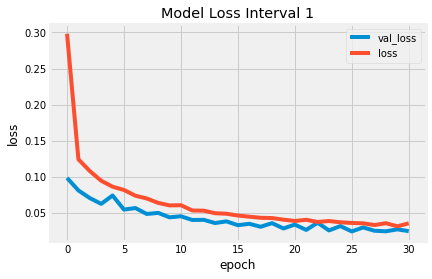

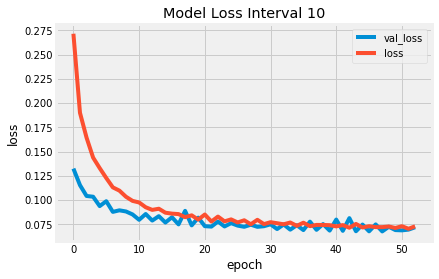

In [11]:
for i in [1,10]:
    plt.plot(model_history[i].history['val_loss'])
    plt.plot(model_history[i].history['loss'])
    plt.title('Model Loss Interval {}'.format(i))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['val_loss', 'loss'], loc='upper right')
    plt.show()

## Helper functions

In [12]:
# Calculate Mean squared_error #
def return_mse(test,predicted):
    mse = mean_squared_error(test, predicted)
    return mse

In [13]:
# Plotting graph
def plotting_graph(y_test, y_pred, ticker, des):
    plt.plot(y_test, color='green', label='Actual adj_close value')
    plt.plot(y_pred, color='red', label='Predicted adj_close value')
    plt.title('Prediction of {} on {}'.format(ticker, des))
    plt.xlabel('Time steps')
    plt.ylabel('adj_close value')
    plt.legend()
    plt.show()

# Predict with Test Set

In [14]:
def make_test_data(s):
    scaler = {s:{}}
    test_set = {s:{}}
    test_set.update({s:{
            'x_1':{},
            'x_2':{},
            'x_3':{},
            'y':{},
        }})
    for i in prediction_intervals:
            test_set[s]['x_1'][i] = []
            test_set[s]['x_2'][i] = []
            test_set[s]['x_3'][i] = []
            test_set[s]['y'][i] = []
            scaler[s][i] = []

    df = testSet.loc[testSet['ticker'] == s][['adj_close']]
    mv_rate = 20
    data_1 = df.values
    data_1 = data_1[mv_rate -1:]
    
    data_2 = df.rolling(mv_rate).mean().values
    data_2 = data_2[mv_rate-1:]
    
    df = testSet.loc[testSet['ticker'] == s][['volume']]
    data_3 = df.values
    data_3 = data_3[mv_rate -1:]
    
    stop_append = {}
    for i in prediction_intervals:
        stop_append.update({i:False}) 
    l = len(data_1)
    for i in range(timesteps, l):
        x_1 = data_1[i-timesteps: i, 0]
        x_2 = data_2[i-timesteps: i, 0]
        x_3 = data_3[i-timesteps: i, 0]
        for j in stop_append:
            if not stop_append[j]:
                if i+j-1 < l:
                    y = data_1[i+j-1,0]
                    y = y.reshape(-1,1)
                    x_1 = x_1.reshape(-1,1)
                    x_2 = x_2.reshape(-1,1)
                    x_3 = x_3.reshape(-1,1)

                    sc = MinMaxScaler(feature_range=(0,1))
                    sc.partial_fit(x_1)
                    sc.partial_fit(x_2)
                    sc.partial_fit(y)
                    scaler[s][j].append(sc)
                    
                    test_set[s]['x_1'][j].append(sc.transform(x_1))
                    test_set[s]['x_2'][j].append(sc.transform(x_2))
                    test_set[s]['y'][j].append(y)
                    
                    sc = MinMaxScaler(feature_range=(0,1))
                    test_set[s]['x_3'][j].append(sc.fit_transform(x_3))
                    if y == data_1[l-1,0]:
                        stop_append[j] =True
                    
    return test_set, scaler

In [15]:
def make_prediction(data, s, scaler):
    mse_val = {}
    y_true_val = {}
    y_pred_val = {}
    
    for i in prediction_intervals:
        x_test = []
        for j in range (0, len(data[s]['x_1'][i])):
            x = [
                data[s]['x_1'][i][j],
                data[s]['x_2'][i][j],
                data[s]['x_3'][i][j],
            ]
            x_test.append(x)

        X_test = np.array(x_test)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])
        
        result = model[i].predict(X_test)
        y_pred = []
        for j in range(0,len(result)):
            y = result[j]
            y = y.reshape(-1,1)
            k = scaler[s][i][j].inverse_transform(y)
            y_pred.append(k[0][0])
                    
        y_test = data[s]['y'][i]
        y_true = np.array(y_test)
        y_true = y_true.reshape(y_true.shape[0])
    
        y_true_val[i] = y_true
        y_pred_val[i] = y_pred

        mse_val[i] = return_mse(y_true, y_pred) 
    return y_true_val, y_pred_val, mse_val

In [16]:
symbols[:100]

array(['A', 'AA', 'AABA', 'AAL', 'AAME', 'AAN', 'AAOI', 'AAON', 'AAP',
       'AAPL', 'AAT', 'AAV', 'AAWW', 'AAXJ', 'AAXN', 'AB', 'ABAC', 'ABAX',
       'ABB', 'ABBV', 'ABC', 'ABCB', 'ABCD', 'ABDC', 'ABEO', 'ABEV',
       'ABG', 'ABIL', 'ABIO', 'ABM', 'ABMD', 'ABR', 'ABT', 'ABTX', 'ABUS',
       'ABX', 'AC', 'ACAD', 'ACBI', 'ACC', 'ACCO', 'ACER', 'ACET', 'ACGL',
       'ACGLO', 'ACGLP', 'ACH', 'ACHC', 'ACHN', 'ACHV', 'ACIA', 'ACIU',
       'ACIW', 'ACLS', 'ACM', 'ACMR', 'ACN', 'ACNB', 'ACOR', 'ACP',
       'ACRE', 'ACRS', 'ACRX', 'ACSF', 'ACST', 'ACT', 'ACTG', 'ACWI',
       'ACWX', 'ACXM', 'ADAP', 'ADBE', 'ADC', 'ADES', 'ADI', 'ADM',
       'ADMA', 'ADMP', 'ADMS', 'ADNT', 'ADOM', 'ADP', 'ADRA', 'ADRD',
       'ADRE', 'ADRO', 'ADRU', 'ADS', 'ADSK', 'ADSW', 'ADTN', 'ADUS',
       'ADVM', 'ADX', 'ADXS', 'AEB', 'AED', 'AEE', 'AEG', 'AEGN'],
      dtype=object)

## Predicting sample

In [17]:
s = 'AAPL'
data, sc = make_test_data(s)
y_true_val, y_pred_val, mse_val = make_prediction(data, s, sc)

for i in mse_val:
    print('Test Set -> MSE of {} inveral {}: {}'.format(s, i, mse_val[i]))

Test Set -> MSE of AAPL inveral 1: 14.671927583275737
Test Set -> MSE of AAPL inveral 3: 31.39750413337795
Test Set -> MSE of AAPL inveral 5: 44.808520734494884
Test Set -> MSE of AAPL inveral 10: 70.42536384425192


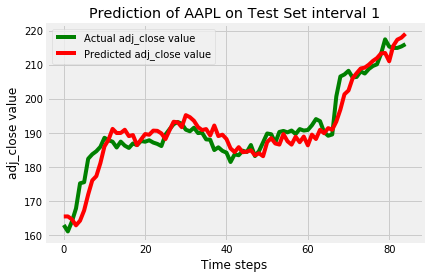

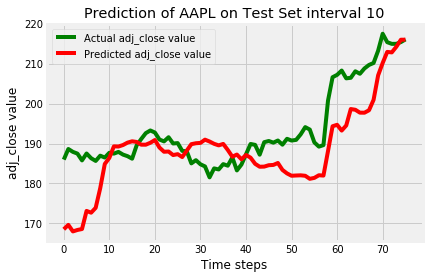

In [18]:
for i in [1,10]:
    plotting_graph(y_true_val[i], y_pred_val[i], s, 'Test Set interval {}'.format(i))

# MSE of 10 symbols

In [19]:
test_symbols = ['A','ACER','MSFT','ABC','AAPL']

In [20]:
all_mse = {}
for s in test_symbols:
    all_mse[s] = {}
    data, sc = make_test_data(s)
    y_true_val, y_pred_val, mse_val = make_prediction(data, s, sc)
    for i in prediction_intervals:
        all_mse[s][i] = mse_val[i]
        all_mse[s][i] = mse_val[i]

In [21]:
all_mse_1 = []
all_mse_10 = []
for s in all_mse:
    all_mse_1.append(round(all_mse[s][1], 2))
    all_mse_10.append(round(all_mse[s][10], 2))

## MSE of interval 1

In [22]:
all_mse_1

[2.2, 2.06, 2.31, 5.47, 14.67]

## MSE of Interval 10

In [23]:
all_mse_10

[3.92, 6.77, 7.1, 19.55, 70.43]

In [24]:
for i in range(0, len(all_mse_1)):
    print('MSE of Interval 10 = {} * Interval 1'.format(round(all_mse_10[i]/all_mse_1[i], 2)))

MSE of Interval 10 = 1.78 * Interval 1
MSE of Interval 10 = 3.29 * Interval 1
MSE of Interval 10 = 3.07 * Interval 1
MSE of Interval 10 = 3.57 * Interval 1
MSE of Interval 10 = 4.8 * Interval 1
